In [1]:
import sys
dirname = '/Users/muhammaddaffarobani/Documents/personal_research/smt'
if dirname not in sys.path:
    sys.path.append(dirname)

import pandas as pd
import numpy as np
from smt.surrogate_models import KRG
from smt.problems import WingWeight
from smt.sampling_methods import LHS
from sklearn.metrics import mean_squared_error


from smt.explainability_tools import PartialDependenceDisplay, PDFeatureImportanceDisplay
from smt.explainability_tools import partial_dependence, pd_feature_importance

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


In [2]:
ndoe = 625 
fun = WingWeight()
sampling = LHS(xlimits=fun.xlimits, criterion='ese', random_state=1)
X = sampling(ndoe)
y = fun(X)

n_train = int(0.8*ndoe)

X_tr, y_tr = X[:n_train, :], y[:n_train]
X_te, y_te = X[n_train:, :], y[n_train:]

In [3]:
kriging_model = KRG(
    theta0=[1e-2]*X_tr.shape[1],
    print_prediction = False
    )
kriging_model.set_training_values(
    X_tr, 
    y_tr
    )

kriging_model.train()
y_pred = kriging_model.predict_values(X_te)
rmse = mean_squared_error(y_te, y_pred, squared=False)
print(f"RMSE: {rmse:.4f}")


___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 500
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec): 14.9501541
RMSE: 0.0470


In [5]:
from itertools import product
from scipy.special import comb

def create_mask_array(m):
    mask = np.array(list(product(
        range(2), 
        repeat=m,
        )
    ))
    # remove mask where all elements are 0 / 1
    mask = mask[
        (~np.all(mask==0, axis=1)) & 
        (~np.all(mask==1, axis=1))
    ]
    return mask

def calculate_weight(mask_row):
    m = len(mask_row)
    z = np.sum(mask_row)
    numerator = m - 1
    denominator = comb(m, z) * z * (m-z)
    weight = numerator / denominator
    return weight
    

In [6]:
# mean of training data
mean_features = X_tr.mean(axis=0)

instance = X_te[0, :]
instance = instance.reshape(1, -1)
print(instance)
print(f"model prediction: {kriging_model.predict_values(instance)}")

# create mask 
mask = create_mask_array(instance.shape[1])


[[ 1.71777629e+02  2.48378314e+02  9.85956582e+00 -9.25485700e+00
   1.85577918e+01  6.45226966e-01  1.17330897e-01  4.14378706e+00
   1.95665267e+03  3.50452863e-02]]
model prediction: [[291.03677535]]


In [7]:
s_with_zero = mask * instance
assert(s_with_zero.shape==mask.shape)
s_full = (s_with_zero == 0) * mean_features + s_with_zero
assert(s_full.shape==s_with_zero.shape)

weights = np.apply_along_axis(
    calculate_weight,
    1, 
    mask
)

In [8]:
def compute_shap_values(
        mask, 
        s_full,
        weights,
        mean_features,
        model, 
):
    y = model.predict_values(s_full)
    b0 = model.predict_values(mean_features.reshape(1, -1))
    y = y - b0

    w = np.diag(weights)

    b = np.dot(
        np.linalg.inv(np.dot(np.dot(mask.transpose(), w), mask)), 
        np.dot(np.dot(mask.transpose(), w), y)
    )
    return b

    

In [9]:
b = compute_shap_values(
    mask,
    s_full,
    weights, 
    mean_features, 
    kriging_model,
)

In [10]:
b

array([[-4.36184190e+00],
       [-1.51027280e-02],
       [ 3.42406924e+01],
       [ 3.28381761e+00],
       [-7.87458971e-01],
       [-1.61616377e+00],
       [ 8.18948707e+00],
       [-3.46676149e+00],
       [-9.79747323e+00],
       [-2.99854481e+00]])

# individual shapley values

In [6]:
from itertools import product
from scipy.special import comb

def create_mask_array(m):
    mask = np.array(list(product(
        range(2), 
        repeat=m,
        )
    ))
    # remove mask where all elements are 0 / 1
    mask = mask[
        (~np.all(mask==0, axis=1)) & 
        (~np.all(mask==1, axis=1))
    ]
    return mask

def calculate_weight(mask_row):
    m = len(mask_row)
    z = np.sum(mask_row)
    numerator = m - 1
    denominator = comb(m, z) * z * (m-z)
    weight = numerator / denominator
    return weight

def compute_shap_values(
        mask, 
        s_full,
        weights,
        mean_features,
        model, 
):
    y = model.predict_values(s_full)
    b0 = model.predict_values(mean_features.reshape(1, -1))
    y = y - b0

    w = np.diag(weights)

    b = np.dot(
        np.linalg.inv(np.dot(np.dot(mask.transpose(), w), mask)), 
        np.dot(np.dot(mask.transpose(), w), y)
    )
    b = b.reshape(-1, )
    return b

    

def individual_shap_values(
        instances, 
        model, 
        x, 
):
    mean_features = x.mean(axis=0)
    shap_values = list()
    
    for instance in instances:
        instance = instance.reshape(1, -1)
        mask = create_mask_array(instance.shape[1])
        s_with_zero = mask * instance
        s_full = (s_with_zero == 0) * mean_features + s_with_zero

        weights = np.apply_along_axis(
            calculate_weight,
            1, 
            mask,
        )
        shap_value = compute_shap_values(
            mask,
            s_full,
            weights,
            mean_features,
            model,
        )
        shap_values.append(shap_value)
    shap_values = np.array(shap_values)
    return shap_values
        

In [17]:
instances = X_te[0:1, :]
x = X_tr
model = kriging_model

in_shap_values = individual_shap_values(
    instances, 
    model,
    x,
)


(10,)

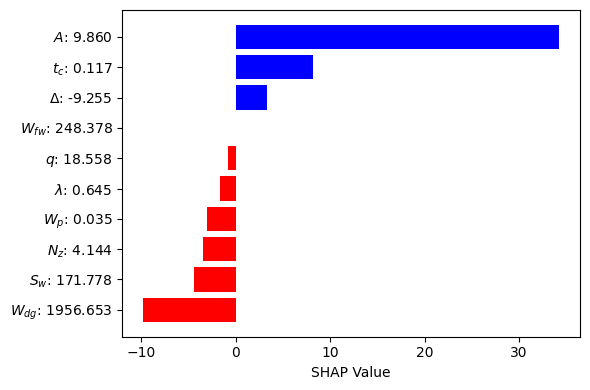

In [20]:
feature_names = [r'$S_{w}$', r'$W_{fw}$', r'$A$', r'$\Delta$', 
                 r'$q$', r'$\lambda$', r'$t_{c}$',
                 r'$N_{z}$', r'$W_{dg}$', r'$W_{p}$']
instance = instances[0]
shap_value = in_shap_values[0] 

ticks = [f"{feature_name}: {value:.3f}" for feature_name, value in zip(feature_names, instance)]
ticks = np.array(ticks)

ticks = ticks[np.argsort(shap_value)]
shap_value = shap_value[np.argsort(shap_value)]
colors = ["blue" if value >= 0 else "red" for value in shap_value ]

fig, ax = plt.subplots(1, 1, figsize=[6, 4])
ax.barh(
    np.arange(len(shap_value)), 
    shap_value,
    color=colors,
    )
ax.set_yticks(np.arange(len(shap_value)))
ax.set_yticklabels(ticks)
ax.set_xlabel("SHAP Value")

fig.tight_layout()
plt.savefig("example_results/shap/individual_explainer.png")


# feature importance

In [15]:
instances = X_tr[:, :]
x = X_tr
model = kriging_model

in_shap_values = individual_shap_values(
    instances, 
    model,
    x,
)


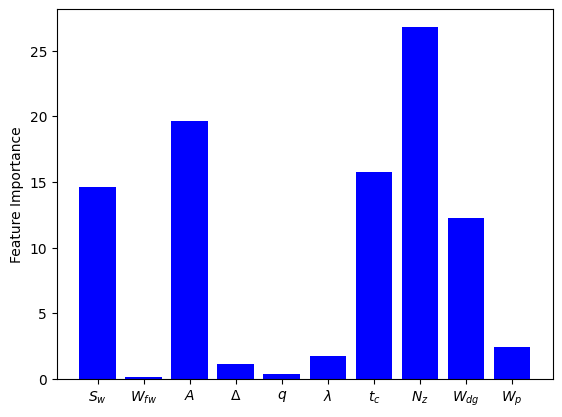

In [16]:
feature_names = [r'$S_{w}$', r'$W_{fw}$', r'$A$', r'$\Delta$', 
                 r'$q$', r'$\lambda$', r'$t_{c}$',
                 r'$N_{z}$', r'$W_{dg}$', r'$W_{p}$']

plt.bar(
    np.arange(1, X_tr.shape[1]+1),
    np.abs(in_shap_values).mean(axis=0),
    color="blue",
)
plt.xticks(np.arange(1, X_tr.shape[1]+1), feature_names)
plt.ylabel("Feature Importance")
plt.savefig("example_results/shap/feature_importance.png")
plt.show()

# dependence plot

In [17]:
# instances = X_tr[:, :]
# x = X_tr
# model = kriging_model


# in_shap_values = individual_shap_values(
#     instances, 
#     model,
#     x,
# )


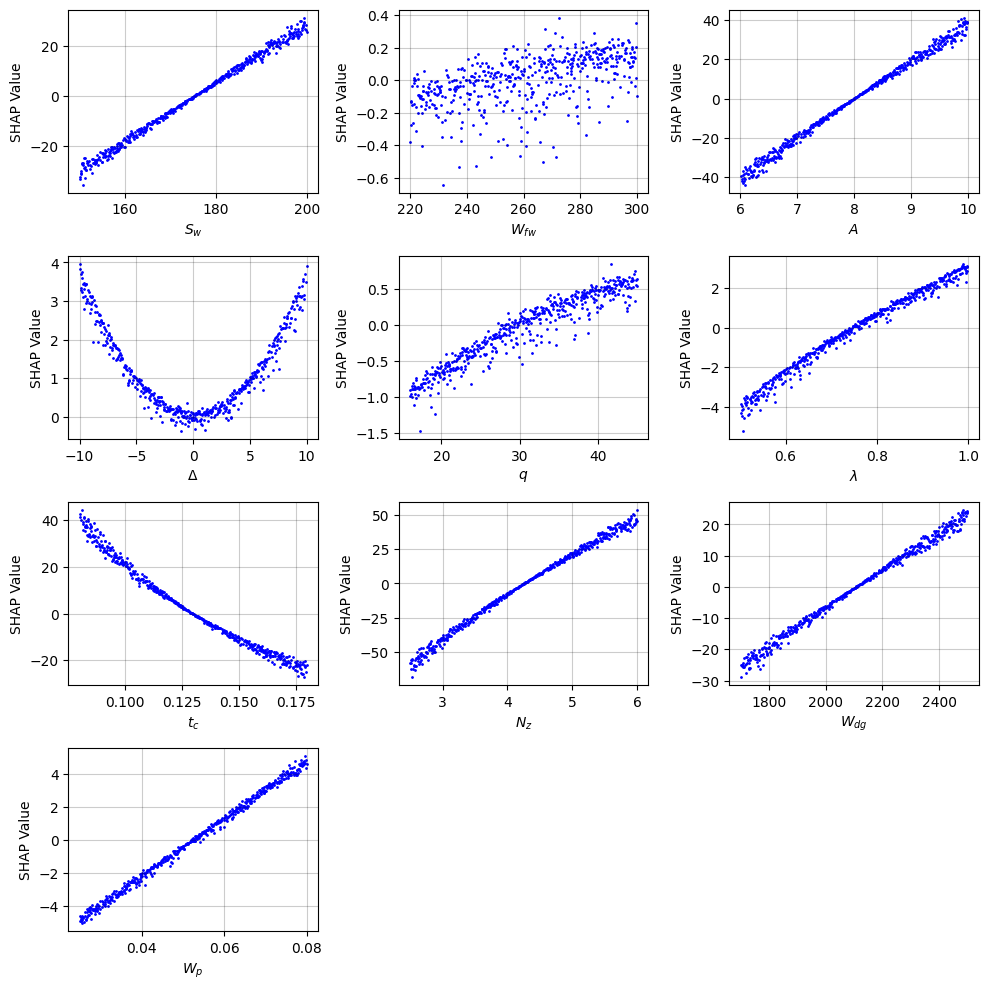

In [18]:
feature_names = [r'$S_{w}$', r'$W_{fw}$', r'$A$', r'$\Delta$', 
                 r'$q$', r'$\lambda$', r'$t_{c}$',
                 r'$N_{z}$', r'$W_{dg}$', r'$W_{p}$']

fig, axs = plt.subplots(4, 3, figsize=[10, 10])
fig.delaxes(axs[3, 1])
fig.delaxes(axs[3, 2])
for i in range(x.shape[1]):
    row = i // 3
    col = i % 3
    axs[row, col].scatter(instances[:, i], in_shap_values[:, i], color="blue", s=1)
    axs[row, col].set_xlabel(feature_names[i])
    axs[row, col].set_ylabel("SHAP Value")
    axs[row, col].grid(color="black", alpha=0.2)

fig.tight_layout()
plt.savefig("example_results/shap/dependence_plot.png")


# interaction plot

In [23]:
instances = X_tr[:, :]
x = X_tr
model = kriging_model


in_shap_values = individual_shap_values(
    instances, 
    model,
    x,
)

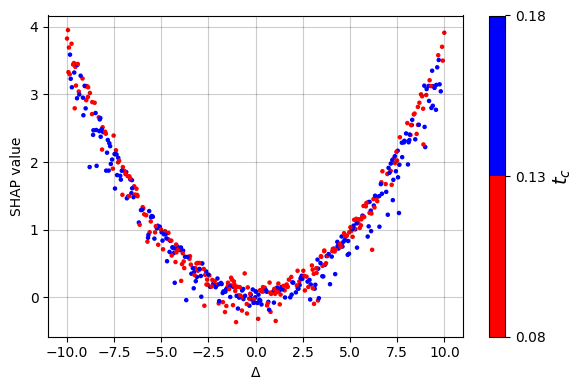

In [24]:
feature_names = [r'$S_{w}$', r'$W_{fw}$', r'$A$', r'$\Delta$', 
                 r'$q$', r'$\lambda$', r'$t_{c}$',
                 r'$N_{z}$', r'$W_{dg}$', r'$W_{p}$']

i = 3
j = 6

fig, ax = plt.subplots(1, 1, figsize=[6, 4])

median_value = np.quantile(x[:, j], 0.5)
cbar_ticks = [x[:, j].min(), median_value, x[:, j].max()]
cbar_ticks = [f"{value:.2f}" for value in cbar_ticks]
colors_flag = [1 if value>=median_value else -1 for value in x[:, j]]
colors = ['red', 'blue']
cmap = ListedColormap(colors)

im = ax.scatter(x[:, i], in_shap_values[:, i], s=5, c=colors_flag, cmap=cmap)
cbar = plt.colorbar(im, ax=ax)
cbar.set_label(feature_names[j], fontsize=14)
cbar.set_ticks([-1, 0, 1])
cbar.set_ticklabels(cbar_ticks)


ax.grid(color="black", alpha=0.2)
ax.set_xlabel(feature_names[i])
ax.set_ylabel("SHAP value")

fig.tight_layout()
# plt.savefig("example_results/shap/interaction_plot.png")

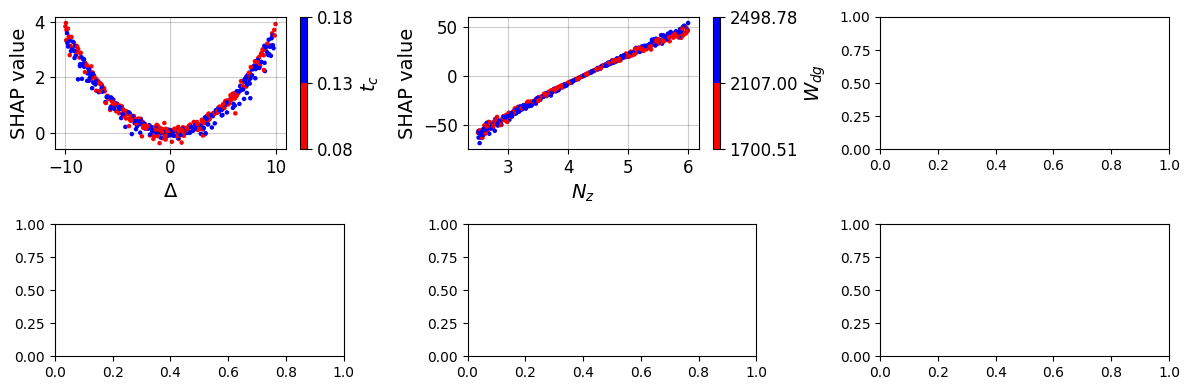

In [37]:
features = [
    (3, 6),
    (7, 8)
]

fig, axs = plt.subplots(2, 3, figsize=[12, 4])

for i in range(len(features)):
    feature_idx = features[i][0]
    interacted_feature_idx = features[i][1]

    median_value = np.quantile(x[:, interacted_feature_idx], 0.5)
    cbar_ticks = [x[:, interacted_feature_idx].min(), median_value, x[:, interacted_feature_idx].max()]
    cbar_ticks = [f"{value:.2f}" for value in cbar_ticks]
    colors_flag = [1 if value>=median_value else -1 for value in x[:, interacted_feature_idx]]
    colors = ['red', 'blue']
    cmap = ListedColormap(colors)

    

    row = i // 3
    col = i % 3
    im = axs[row, col].scatter(x[:, feature_idx], in_shap_values[:, feature_idx], s=5, c=colors_flag, cmap=cmap)

    axs[row, col].grid(color="black", alpha=0.2)
    axs[row, col].set_xlabel(feature_names[feature_idx], fontsize=14)
    axs[row, col].set_ylabel("SHAP value", fontsize=14)
    axs[row, col].xaxis.set_tick_params(labelsize=12)
    axs[row, col].yaxis.set_tick_params(labelsize=12)

    cbar = plt.colorbar(im, ax=axs[row, col])
    cbar.set_label(feature_names[interacted_feature_idx], fontsize=14)
    cbar.set_ticks([-1, 0, 1])
    cbar.set_ticklabels(cbar_ticks, fontsize=12)


fig.tight_layout()

In [25]:
# feature_names = [r'$S_{w}$', r'$W_{fw}$', r'$A$', r'$\Delta$', 
#                  r'$q$', r'$\lambda$', r'$t_{c}$',
#                  r'$N_{z}$', r'$W_{dg}$', r'$W_{p}$']

# i = 7
# j = 8

# fig, ax = plt.subplots(1, 1, figsize=[6, 4])

# median_value = np.quantile(x[:, j], 0.5)
# cbar_ticks = [x[:, j].min(), median_value, x[:, j].max()]
# cbar_ticks = [f"{value:.2f}" for value in cbar_ticks]
# colors_flag = [1 if value>=median_value else -1 for value in x[:, j]]
# colors = ['red', 'blue']
# cmap = ListedColormap(colors)

# im = ax.scatter(x[:, i], in_shap_values[:, i], s=5, c=colors_flag, cmap=cmap)
# cbar = plt.colorbar(im, ax=ax)
# cbar.set_label(feature_names[j], fontsize=14)
# # cbar.set_ticks([x[:, j].min(), median_value, x[:, j].max()])
# cbar.set_ticks([-1, 0, 1])
# cbar.set_ticklabels(cbar_ticks)


# ax.grid(color="black", alpha=0.2)
# ax.set_xlabel(feature_names[i])
# ax.set_ylabel("SHAP values")

# fig.tight_layout()

In [26]:
# feature_names = [r'$S_{w}$', r'$W_{fw}$', r'$A$', r'$\Delta$', 
#                  r'$q$', r'$\lambda$', r'$t_{c}$',
#                  r'$N_{z}$', r'$W_{dg}$', r'$W_{p}$']

# i = 1
# j = 7

# fig, ax = plt.subplots(1, 1, figsize=[6, 4])

# min_value = x[:, j].min()
# max_value = x[:, j].max()
# median_value = np.quantile(x[:, j], 0.5)
# colors_flag = (x[:, j] - min_value) / (max_value - min_value)
# cmap = plt.cm.RdBu
# cbar_ticks = [min_value, median_value, max_value]
# cbar_ticks = [f"{value:.2f}" for value in cbar_ticks]


# im = ax.scatter(x[:, i], in_shap_values[:, i], s=5, c=colors_flag, cmap=cmap)
# cbar = plt.colorbar(im, ax=ax)
# cbar.set_label(feature_names[j], fontsize=14)
# # cbar.set_ticks([x[:, j].min(), median_value, x[:, j].max()])
# cbar.set_ticks([0, 0.5, 1])
# cbar.set_ticklabels(cbar_ticks)


# ax.grid(color="black", alpha=0.2)
# ax.set_xlabel(feature_names[i])
# ax.set_ylabel("SHAP values")

# fig.tight_layout()

# summary plot

In [23]:
# instances = X_tr[:, :]
# x = X_tr
# model = kriging_model

# in_shap_values = individual_shap_values(
#     instances, 
#     model,
#     x,
# )


In [40]:
feature_importances = np.abs(in_shap_values).mean(axis=0)
feature_names = [r'$S_{w}$', r'$W_{fw}$', r'$A$', r'$\Delta$', 
                 r'$q$', r'$\lambda$', r'$t_{c}$',
                 r'$N_{z}$', r'$W_{dg}$', r'$W_{p}$']

In [41]:
features = np.arange(x.shape[1])
feature_names = np.array(feature_names)
sorted_features = features[np.argsort(feature_importances*-1)]
sorted_feature_names = feature_names[np.argsort(feature_importances*-1)]

In [260]:
# def rand_jitter(arr):
#     stdev = 1 * (max(arr) - min(arr))
#     return arr + np.random.randn(len(arr)) * stdev

In [42]:
# fig, ax = plt.subplots(1, 1, figsize=[5, 4])
# vis_indexes = np.arange(0, -1 * len(features), -1)
# colors = ['red', 'blue']
# cmap = ListedColormap(colors)

# for i, vis_index in enumerate(vis_indexes):
#     feature_index = sorted_features[i]
#     median_value = np.quantile(x[:, feature_index], 0.5)
#     colors_flag = [1 if value>=median_value else -1 for value in x[:, feature_index]]

#     im = ax.scatter(
#         in_shap_values[:, feature_index],
#         [vis_index]*len(in_shap_values),
#         c = colors_flag,
#         cmap=cmap,
#         s=5,
#     )

# ax.axvline(0, color="black")

# ax.set_yticks(vis_indexes)
# ax.set_yticklabels(sorted_feature_names[:])
# ax.set_xlabel("SHAP Values")

# cbar = plt.colorbar(im, ax=ax) 
# cbar.set_label("Feature values", fontsize=12)
# cbar.set_ticks([-1, 1])
# cbar.set_ticklabels(["Low", "High"])

# fig.tight_layout()

In [43]:
def jitter_y_based_on_x(
        x, 
        y, 
        num_grid,
        min_value, 
        max_value,
        max_strength=0.2
):
    delta = (max_value - min_value) / num_grid
    groups = x // delta
    prop_groups = dict()
    for value in np.unique(groups):
        prop_groups[value] = np.mean(groups==value)
    
    jitter_scales = np.ones(len(y))
    for i in range(len(groups)):
        if prop_groups[groups[i]] < 2 / num_grid:
            jitter_scale = 0
        else:
            jitter_scale = (prop_groups[groups[i]] - 0.1) * max_strength
            jitter_scale = min(max_strength, jitter_scale)
        jitter_scales[i] = jitter_scale

    y = np.array(y)
    y_jitter = y + np.random.randn(len(y)) * jitter_scales
    return y_jitter


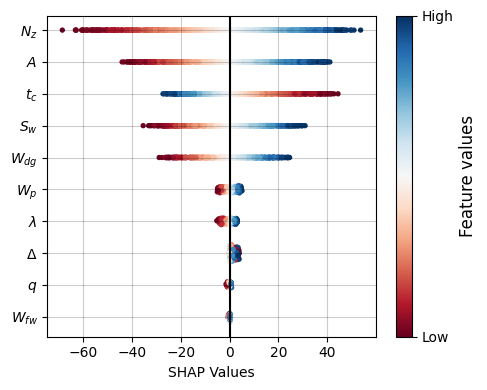

In [44]:
fig, ax = plt.subplots(1, 1, figsize=[5, 4])
vis_indexes = np.arange(0, -1 * len(features), -1)
# colors = ['red', 'blue']
# cmap = ListedColormap(colors)
cmap = plt.cm.RdBu

for i, vis_index in enumerate(vis_indexes):
    feature_index = sorted_features[i]
    min_feature_value = x[:, feature_index].min()
    max_feature_value = x[:, feature_index].max()
    colors_flag = (x[:, feature_index] - min_feature_value) / (max_feature_value - min_feature_value)

    x_vis = in_shap_values[:, feature_index]
    y_vis = jitter_y_based_on_x(
        x_vis, 
        [vis_index]*len(in_shap_values),
        20, 
        in_shap_values.min(), 
        in_shap_values.max(),
        max_strength=0.1,
    )
    im = ax.scatter(
        x_vis,
        y_vis,
        c = colors_flag,
        cmap=cmap,
        s=8,
    )

ax.axvline(0, color="black")

ax.set_yticks(vis_indexes)
ax.set_yticklabels(sorted_feature_names[:])
ax.set_xlabel("SHAP Values")

cbar = plt.colorbar(im, ax=ax) 
cbar.set_label("Feature values", fontsize=12)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(["Low", "High"])

ax.grid(color="black", alpha=0.2)

fig.tight_layout()
plt.savefig("example_results/shap/summary_plot_1.png")

In [48]:
len(x_vis)

500

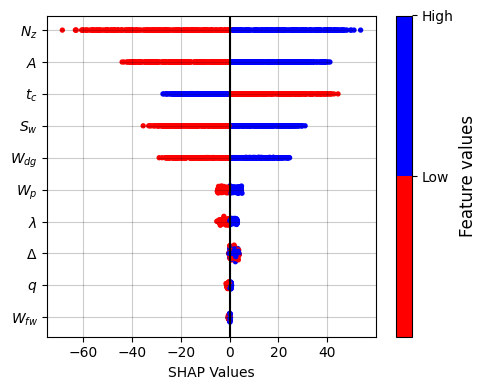

In [27]:
fig, ax = plt.subplots(1, 1, figsize=[5, 4])
vis_indexes = np.arange(0, -1 * len(features), -1)
colors = ['red', 'blue']
cmap = ListedColormap(colors)

for i, vis_index in enumerate(vis_indexes):
    feature_index = sorted_features[i]
    median_value = np.quantile(x[:, feature_index], 0.5)
    colors_flag = [1 if value>=median_value else -1 for value in x[:, feature_index]]

    x_vis = in_shap_values[:, feature_index]
    y_vis = jitter_y_based_on_x(
        x_vis, 
        [vis_index]*len(in_shap_values),
        20, 
        in_shap_values.min(), 
        in_shap_values.max(),
        max_strength=0.1,
    )
    im = ax.scatter(
        x_vis,
        y_vis,
        c = colors_flag,
        cmap=cmap,
        s=8,
    )

ax.axvline(0, color="black")

ax.set_yticks(vis_indexes)
ax.set_yticklabels(sorted_feature_names[:])
ax.set_xlabel("SHAP Values")

cbar = plt.colorbar(im, ax=ax) 
cbar.set_label("Feature values", fontsize=12)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(["Low", "High"])

ax.grid(color="black", alpha=0.2)

fig.tight_layout()
plt.savefig("example_results/shap/summary_plot_2.png")